<a href="https://colab.research.google.com/github/bdtranter/cifar_10/blob/main/SimpleNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 44.4MB/s]


Epoch [1/10]
  Train Loss: 1.4357, Train Acc: 49.73%
  Test  Loss: 1.3008, Test  Acc: 53.92%
Epoch [2/10]
  Train Loss: 1.1698, Train Acc: 59.30%
  Test  Loss: 1.1485, Test  Acc: 59.97%
Epoch [3/10]
  Train Loss: 1.0667, Train Acc: 63.11%
  Test  Loss: 1.1526, Test  Acc: 60.25%
Epoch [4/10]
  Train Loss: 1.0034, Train Acc: 65.45%
  Test  Loss: 1.0921, Test  Acc: 62.59%
Epoch [5/10]
  Train Loss: 0.9712, Train Acc: 66.57%
  Test  Loss: 1.1123, Test  Acc: 61.91%
Epoch [6/10]
  Train Loss: 0.9373, Train Acc: 67.77%
  Test  Loss: 1.0980, Test  Acc: 62.71%
Epoch [7/10]
  Train Loss: 0.9111, Train Acc: 68.75%
  Test  Loss: 1.0674, Test  Acc: 63.59%
Epoch [8/10]
  Train Loss: 0.8920, Train Acc: 69.37%
  Test  Loss: 1.0680, Test  Acc: 63.98%
Epoch [9/10]
  Train Loss: 0.8759, Train Acc: 69.90%
  Test  Loss: 1.0936, Test  Acc: 63.02%
Epoch [10/10]
  Train Loss: 0.8598, Train Acc: 70.38%
  Test  Loss: 1.0721, Test  Acc: 64.39%


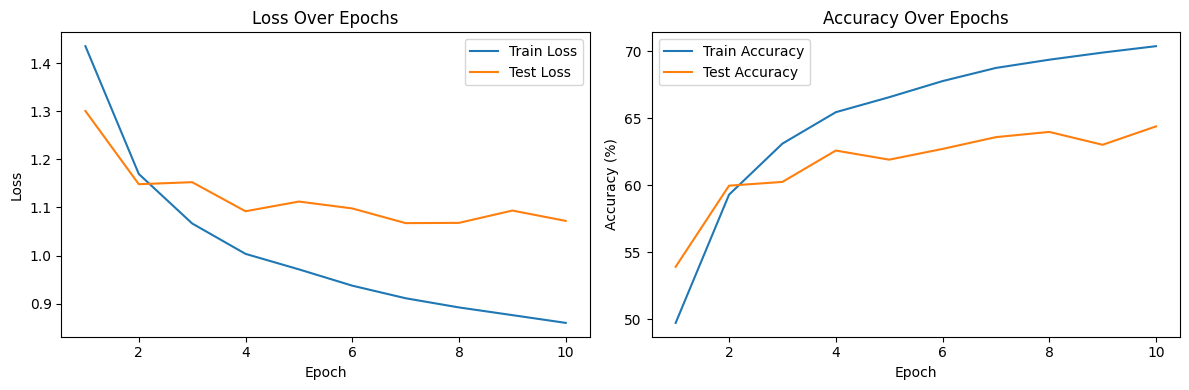

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

############################################
#        Data Loaders and Transforms       #
############################################
def get_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

############################################
#          Simple CNN Model Class          #
############################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=5, padding=2)  # (B, 16, 32, 32)
        self.pool = nn.MaxPool2d(2, 2)                          # (B, 16, 16, 16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))                    # (B, 16, 16, 16)
        x = x.view(x.size(0), -1)                              # Flatten
        x = self.dropout(x)                                    # Dropout for regularization
        x = self.fc(x)                                         # Fully connected output
        return x

############################################
#              Training Loop               #
############################################
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

############################################
#             Evaluation Loop              #
############################################
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

############################################
#               Main Script                #
############################################
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = get_data_loaders()
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

